# Cython Analysis

The dual_autodiff package has a Cythonized version called dual_autodiff_x. Let's analyse the performances for both of the packages.

In [9]:
#import the required packages
import numpy as np
import matplotlib.pyplot as plt
from dual_autodiff import dual, tools
from dual_autodiff_x import dual as dual_x, tools as tools_x

In [14]:
import numpy as np
import time
import matplotlib.pyplot as plt
from typing import List, Tuple
import seaborn as sns
from dual_autodiff import dual, tools
from dual_autodiff_x import dual as dual_x, tools as tools_x

def sigmoid(x):
    """Sigmoid function implementation"""
    return 1 / (np.exp(-x)+1)

def sigmoid_derivative(x):
    """Derivative of sigmoid function"""
    s = sigmoid(x)
    return s * (1 - s)

def benchmark_operation(operation: str, sizes: List[int], 
                       py_dual, cy_dual, num_trials: int = 5) -> Tuple[List[float], List[float]]:
    """
    Benchmark a specific operation for both Python and Cython implementations
    """
    py_times = []
    cy_times = []
    
    for size in sizes:
        py_total = 0
        cy_total = 0
        
        for _ in range(num_trials):
            x_vals = np.random.rand(size)
            
            # Python version timing
            py_start = time.time()
            for i in range(size):
                x = py_dual(x_vals[i], {'x': 1.0})
                if operation in ['add', 'mul', 'div', 'pow']:
                    y = py_dual(x_vals[i], {'y': 1.0})
                    if operation == 'add':
                        result = x + y
                    elif operation == 'mul':
                        result = x * y
                    elif operation == 'div':
                        result = x / y
                    elif operation == 'pow':
                        result = x ** y
                elif operation == 'sin':
                    result = np.sin(x)
                elif operation == 'exp':
                    result = np.exp(x)
                elif operation == 'sigmoid':
                    result = sigmoid(x)
            py_total += time.time() - py_start
            
            # Cython version timing
            cy_start = time.time()
            for i in range(size):
                x = cy_dual(x_vals[i], {'x': 1.0})
                if operation in ['add', 'mul', 'div', 'pow']:
                    y = cy_dual(x_vals[i], {'y': 1.0})
                    if operation == 'add':
                        result = x + y
                    elif operation == 'mul':
                        result = x * y
                    elif operation == 'div':
                        result = x / y
                    elif operation == 'pow':
                        result = x ** y
                elif operation == 'sin':
                    result = np.sin(x)
                elif operation == 'exp':
                    result = np.exp(x)
                elif operation == 'sigmoid':
                    result = sigmoid(x)
            cy_total += time.time() - cy_start
            
        py_times.append(py_total / num_trials)
        cy_times.append(cy_total / num_trials)
    
    return py_times, cy_times

def run_benchmarks(py_dual, cy_dual):
    """Run comprehensive benchmarks and create visualization"""
    # Add the sigmoid function to both implementations
    tools.base_implementations['sigmoid'] = (sigmoid, sigmoid_derivative)
    tools_x.base_implementations['sigmoid'] = (sigmoid, sigmoid_derivative)
    
    operations = ['add', 'mul', 'div', 'pow', 'sin', 'exp', 'sigmoid']
    sizes = [100, 1000, 5000, 10000, 50000]
    
    plt.figure(figsize=(20, 12))
    
    for idx, op in enumerate(operations, 1):
        plt.subplot(2, 4, idx)
        py_times, cy_times = benchmark_operation(op, sizes, py_dual, cy_dual)
        
        # Calculate speedup
        speedups = [py/cy for py, cy in zip(py_times, cy_times)]
        
        # Plot timing comparison
        plt.plot(sizes, py_times, 'o-', label='Python', color='blue')
        plt.plot(sizes, cy_times, 'o-', label='Cython', color='red')
        
        plt.title(f'{op.capitalize()} Operation\nMax Speedup: {max(speedups):.2f}x')
        plt.xlabel('Input Size')
        plt.ylabel('Time (seconds)')
        plt.grid(True)
        plt.legend()
        
        # Log scale for better visualization
        plt.yscale('log')
        
    plt.tight_layout()
    return plt

def analyze_memory_usage(py_dual, cy_dual, size: int = 10000):
    """Analyze memory usage of both implementations"""
    import sys
    
    # Create large arrays of dual numbers
    x_vals = np.random.rand(size)
    
    py_duals = py_dual(x_vals[0], {'x': 1.0})
    cy_duals = cy_dual(x_vals[0], {'x': 1.0})
    
    return sys.getsizeof(py_duals), sys.getsizeof(cy_duals)

Memory usage per object: Python=48 bytes, Cython=56 bytes


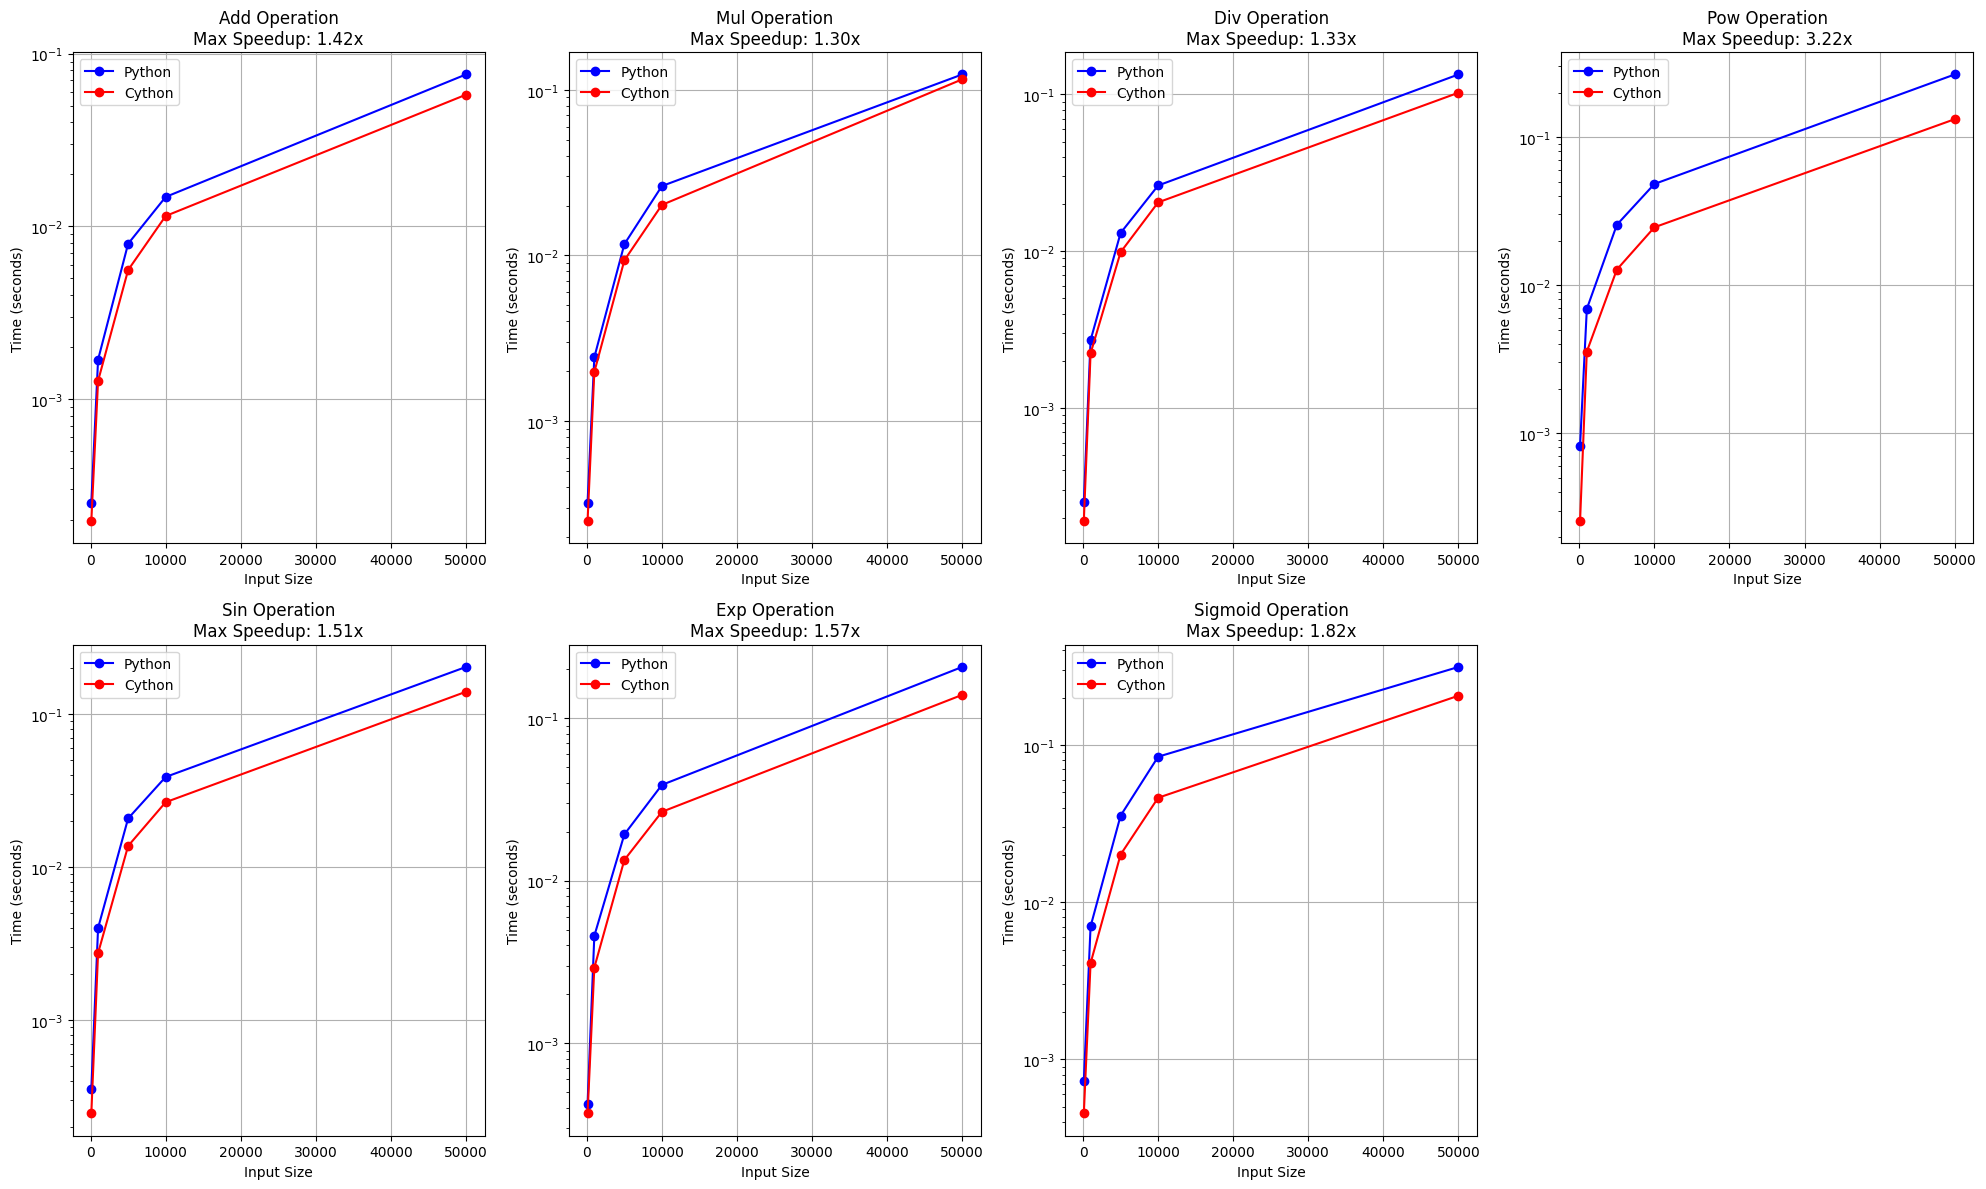

In [15]:
# Run benchmarks
plt = run_benchmarks(dual.Dual, dual_x.Dual)
plt.savefig('dual_benchmarks.png')

# Check memory usage
py_size, cy_size = analyze_memory_usage(dual.Dual, dual_x.Dual)
print(f"Memory usage per object: Python={py_size} bytes, Cython={cy_size} bytes")